In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from ffipy import FFIEC_Client
from io import StringIO


In [287]:
client = FFIEC_Client()
# get a list of RSSD codes for filers on 3/31/2019
filers_RSSD_12312010 = client.retrieve_filers_since_date(ds_name='Call',
                                   reporting_pd_end='12/31/2010',
                                   last_update_date='12/31/2010')
# check how many filers - 5908
len(filers_RSSD_12312010)

6999

In [288]:
failed_banks_df = pd.read_csv('data/failed_banks_dataset.csv')
failed_banks_df['Date'] = pd.to_datetime(failed_banks_df['Closing Date'])
failed_banks_df['Year_failed'] = failed_banks_df['Date'].dt.year
failed_banks_df['Quarter_failed'] = failed_banks_df['Date'].dt.quarter
failed_banks_2010Q4 = failed_banks_df.loc[(failed_banks_df.Year_failed == 2010) & (failed_banks_df.Quarter_failed == 4)]
failed_banks_2010Q4.head()
#failed_banks_2010Q4['CERT'].count()

,Bank Name,City,ST,CERT,Acquiring Institution,Closing Date,Updated Date,Date,Year_failed,Quarter_failed
207,Community National Bank,Lino Lakes,MN,23306,Farmers & Merchants Savings Bank,17-Dec-10,10-Nov-16,2010-12-17,2010,4
208,First Southern Bank,Batesville,AR,58052,Southern Bank,17-Dec-10,29-Jan-19,2010-12-17,2010,4
209,"United Americas Bank, N.A.",Atlanta,GA,35065,State Bank and Trust Company,17-Dec-10,17-Oct-15,2010-12-17,2010,4
210,"Appalachian Community Bank, FSB",McCaysville,GA,58495,Peoples Bank of East Tennessee,17-Dec-10,29-Jan-19,2010-12-17,2010,4
211,Chestatee State Bank,Dawsonville,GA,34578,Bank of the Ozarks,17-Dec-10,21-Sep-15,2010-12-17,2010,4


In [385]:
# Prepare the list of CERT to pull financial metrics in a loop
banks_CERT_2010Q4_list = list(failed_banks_2010Q4.CERT)
banks_CERT_2010Q4_list

In [287]:
financial_metrics_dict = {'RIAD3210':'Total equity capital',
                          'RCON2170':'Total assets',
                          'RCON3360':'Total loans',
                          'RCONC410':'New nonaccrual assets',
                          'RCONC411': 'Sold nonaccrual assets',
                          'RCON3123':'Allowance for loan losses',
                          'RIAD4093':'Total noninterest expense',
                          'RIAD4340':'Net Income attributable',
                          'RCON2215':'Total transaction deposits',
                          'RCON2385':'Total nontransaction deposits',
                          'RCON3545':'Trading assets'}
fin_columns = list(financial_metrics_dict.keys())

In [390]:
#fin_columns

In [373]:
# Pull 30 reports, drop all values but 11 selected metrics -- returns only 27
all_data_df = pd.DataFrame()
fin_data_dic = {}
for i in range(len(banks_CERT_2010Q4_list)):

    ds_name = 'Call'    # Pull Call report data
    end_date = '9/30/2010'  # Pull data in reporting pd ending 3/31/17
    fiID_type = 'FDICCertNumber'  # Type of financial inst identifier (ID_RSSD, CERT )
    fiID = banks_CERT_2010Q4_list[i]   # Indentifier for Wyomin Bank and Trust
    print("counter at ", i, " pulling CERT# ", fiID)
    fmt = 'SDF'  # Pull report as PDF
    # <facsimileFormat>PDF or XBRL or SDF</facsimileFormat>
    #outfile = 'test8.PDF'  # Output file path
    return_result = True  # If True, method returns the data
    try:
        f = client.retrieve_facsimile(ds_name=ds_name, reporting_pd_end=end_date,
                                      fiID_type=fiID_type, fiID=fiID,
                                      facsimile_fmt=fmt, outfile=False,
                                      return_result=True)
        report = StringIO(str(f, 'utf-8'))
        report_df = pd.read_csv(report, sep=';')
        report_df.columns = ['Call Date', 'Bank RSSD Identifier', 'ValueID', 'Value', 'Last Update',
       'Short Definition', 'Call Schedule', 'Line Number']
        values = list(report_df[report_df.ValueID.isin(fin_columns)].Value)
        fin_data_dic[fiID] = values
        all_data_df = all_data_df.append(report_df, ignore_index=True)
    except:
        next 

counter at  0  pulling CERT#  23306
counter at  1  pulling CERT#  58052
counter at  2  pulling CERT#  35065
counter at  3  pulling CERT#  58495
counter at  4  pulling CERT#  34578
counter at  5  pulling CERT#  19040
counter at  6  pulling CERT#  35561
counter at  7  pulling CERT#  34673
counter at  8  pulling CERT#  5287
counter at  9  pulling CERT#  35078
counter at  10  pulling CERT#  20340
counter at  11  pulling CERT#  35463
counter at  12  pulling CERT#  14580
counter at  13  pulling CERT#  57831
counter at  14  pulling CERT#  57885
counter at  15  pulling CERT#  34411
counter at  16  pulling CERT#  58087
counter at  17  pulling CERT#  31263
counter at  18  pulling CERT#  32582
counter at  19  pulling CERT#  22173
counter at  20  pulling CERT#  16089
counter at  21  pulling CERT#  2119
counter at  22  pulling CERT#  33904
counter at  23  pulling CERT#  32251
counter at  24  pulling CERT#  27573
counter at  25  pulling CERT#  34016
counter at  26  pulling CERT#  58205
counter at  2

In [387]:
fin_data_dic.keys()

dict_keys([23306, 58052, 35065, 34578, 19040, 35561, 34673, 5287, 35078, 20340, 35463, 14580, 57831, 57885, 34411, 58087, 31263, 22173, 16089, 2119, 33904, 32251, 27573, 34016, 58205, 35250, 21777])

In [410]:
banks_failed_2010Q4_df = pd.DataFrame.from_dict(fin_data_dic, orient='index')
banks_failed_2010Q4_df.columns = fin_columns
banks_failed_2010Q4_df['Target'] = 1
banks_failed_2010Q4_df['AsOfDate'] = '9/30/2010'
banks_failed_2010Q4_df.to_csv('data/banks_failed_2010Q4')




In [464]:
#all_data_df.to_csv('data/failed_banks_reports2010Q4')
banks_failed_2010Q4_df


,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,Target,AsOfDate
23306,31569,5633,23211,760,16517,0,0,0,2653,2186,-1859,1,9/30/2010
58052,191764,17047,138756,1584,124817,0,0,0,19250,3427,510,1,9/30/2010
35065,242339,13011,180793,14570,188047,0,2924,0,-1833,5865,-16068,1,9/30/2010
34578,244376,29439,211037,3259,180194,0,3133,585,2124,7248,-11104,1,9/30/2010
19040,73295,299323,328903,NaN,-775,17782,-26732,None,None,None,None,1,9/30/2010
35561,112643,7611,96894,2242,78083,0,0,0,2272,3544,-1364,1,9/30/2010
34673,252744,20450,193100,8640,233102,0,6182,0,2571,8568,-10207,1,9/30/2010
5287,750724,36539,628213,37225,572553,0,20081,0,8463,19338,-27757,1,9/30/2010
35078,106595,9706,82290,1289,86882,0,0,0,1474,4679,-4667,1,9/30/2010
20340,112144,37086,75107,3748,74954,0,2109,0,-324,4279,-4286,1,9/30/2010


In [181]:
report_df.columns = ['Call Date', 'Bank RSSD Identifier', 'ValueID', 'Value', 'Last Update',
       'Short Definition', 'Call Schedule', 'Line Number']

In [422]:
client = FFIEC_Client()
# get a list of RSSD codes for filers on 9/30/2010
filers_RSSD_09302010 = client.retrieve_filers_since_date(ds_name='Call',
                                   reporting_pd_end='9/30/2010',
                                   last_update_date='9/30/2010')
# check how many filers - 5908
type(filers_RSSD_09302010)

list

In [432]:
filers_RSSD_09302010[3]


1001451

In [447]:
len(filers_RSSD_09302010)

7094

In [448]:
# Pull 7094 reports that did not fail, drop all values but 11 selected metrics -- returns only 27
all_banks_data_df = pd.DataFrame()
fin_banks_data_dic = {}
for i in range(len(filers_RSSD_09302010)):

    ds_name = 'Call'    # Pull Call report data
    end_date = '9/30/2010'  # Pull data in reporting pd ending 3/31/17
    fiID_type = 'ID_RSSD'  # Type of financial inst identifier (ID_RSSD, CERT )
    fiID = filers_RSSD_09302010[i]   # Indentifier for Wyomin Bank and Trust
    #print("counter at ", i, " pulling RSSD# ", fiID)
    fmt = 'SDF'  # Pull report as PDF
    # <facsimileFormat>PDF or XBRL or SDF</facsimileFormat>
    #outfile = 'test8.PDF'  # Output file path
    return_result = True  # If True, method returns the data
    try:
        f = client.retrieve_facsimile(ds_name=ds_name, reporting_pd_end=end_date,
                                      fiID_type=fiID_type, fiID=fiID,
                                      facsimile_fmt=fmt, outfile=False,
                                      return_result=True)
        report = StringIO(str(f, 'utf-8'))
        report_df = pd.read_csv(report, sep=';')
        report_df.columns = ['Call Date', 'Bank RSSD Identifier', 'ValueID', 'Value', 'Last Update',
       'Short Definition', 'Call Schedule', 'Line Number']
        values = list(report_df[report_df.ValueID.isin(fin_columns)].Value)
        fin_banks_data_dic[fiID] = values
       
        #all_banks_data_df = all_data_df.append(report_df, ignore_index=True)
    except:
        next 

In [450]:
len(fin_banks_data_dic)

7094

In [453]:
len(fin_data_dic)

27

In [454]:
#fin_banks_data_dic.keys()

for i in range(len(fin_data_dic)):
    print('checking ', i)
    try: 
        del fin_banks_data_dic[i]
    except KeyError:
        print("Key 'testing' not found")

# If key is not present in dictionary, then del can throw KeyError
# try:
#     del wordFreqDic["testing"]
# except KeyError:
#     print("Key 'testing' not found")

checking  0
Key 'testing' not found
checking  1
Key 'testing' not found
checking  2
Key 'testing' not found
checking  3
Key 'testing' not found
checking  4
Key 'testing' not found
checking  5
Key 'testing' not found
checking  6
Key 'testing' not found
checking  7
Key 'testing' not found
checking  8
Key 'testing' not found
checking  9
Key 'testing' not found
checking  10
Key 'testing' not found
checking  11
Key 'testing' not found
checking  12
Key 'testing' not found
checking  13
Key 'testing' not found
checking  14
Key 'testing' not found
checking  15
Key 'testing' not found
checking  16
Key 'testing' not found
checking  17
Key 'testing' not found
checking  18
Key 'testing' not found
checking  19
Key 'testing' not found
checking  20
Key 'testing' not found
checking  21
Key 'testing' not found
checking  22
Key 'testing' not found
checking  23
Key 'testing' not found
checking  24
Key 'testing' not found
checking  25
Key 'testing' not found
checking  26
Key 'testing' not found


In [451]:
len(fin_banks_data_dic)

7094

In [484]:
banks_healthy_2010Q4_df = pd.DataFrame.from_dict(fin_banks_data_dic, orient='index')
banks_healthy_2010Q4_df.columns = fin_columns
banks_healthy_2010Q4_df['Target'] = 0
banks_healthy_2010Q4_df['AsOfDate'] = '9/30/2010'
banks_healthy_2010Q4_df.tail()
#banks_healthy_2010Q4_df.to_csv('data/banks_healthy_2010Q4')

In [2]:
#merge with  failed banks

all_banks_2010Q4_df = banks_healthy_2010Q4_df.append(banks_failed_2010Q4_df, ignore_index=True)
all_banks_2010Q4_df.head()
# all_banks_2010Q4_df.to_csv('data/all_banks_2010Q4.csv')


NameError: name 'all_banks_2010Q4_df' is not defined

In [3]:
all_banks_2010Q4_df = pd.read_csv('data/all_banks_2010Q4.csv', index_col=0)
all_banks_2010Q4_df.tail()

,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,Target,AsOfDate
7116,73922,8600,63598,2185.0,56001,0,1976,0.0,-1303.0,2759.0,-6138.0,1,9/30/2010
7117,989382,59159,810208,58180.0,707503,0,51189,0.0,10599.0,23510.0,-33484.0,1,9/30/2010
7118,87782,6779,63352,3165.0,66287,0,1105,0.0,25.0,3153.0,-3459.0,1,9/30/2010
7119,92980,19963,70681,4170.0,70048,0,0,0.0,1131.0,4009.0,-4106.0,1,9/30/2010
7120,402205,21273,345955,20022.0,297286,0,10811,360.0,12540.0,14450.0,-16059.0,1,9/30/2010


In [187]:
all_banks_2010Q4_df.tail()
list(all_banks_2010Q4_df.iloc[7116,:])
#all_banks_2010Q4_df.describe()

[73922,
 8600,
 63598,
 2185.0,
 56001,
 0,
 1976,
 0.0,
 -1303.0,
 2759.0,
 -6138.0,
 1,
 '9/30/2010']

In [4]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.linear_model import LogisticRegression

In [189]:
all_banks_2010Q4_df.dropna(inplace=True)

In [190]:
all_banks_2010Q4_df.groupby(['Target']).count()

,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,AsOfDate
Target,,,,,,,,,,,,
0,6982,6982,6982,6982,6982,6982,6982,6982,6982,6982,6982,6982
1,26,26,26,26,26,26,26,26,26,26,26,26


In [191]:
y = all_banks_2010Q4_df['Target']
X = all_banks_2010Q4_df.drop(['Target', 'AsOfDate'], axis=1)\


In [192]:
#X.tail()

In [193]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)
#list(X.iloc[1, :]


In [194]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_std = scaler.transform(X_train)
X_test_std = scaler.transform(X_test)


# sc = StandardScaler()
# sc.fit(X_train)
# X_train_std = sc.transform(X_train)
# X_test_std = sc.transform(X_test)

In [195]:
log_reg = LogisticRegression(C=1000.0, random_state=1)
log_reg.fit(X_train_std,y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [196]:
log_reg.score(X_train_std, y_train)

0.9960756332500892

In [197]:
log_reg.score(X_test_std, y_test)

0.9957203994293866

In [198]:
predic = list(log_reg.predict(X_test))
predic.index(1)

0

In [199]:
log_reg.coef_

array([[   4.160405  ,    0.67459646,   -6.35699842,    1.13093183,
          26.43318982,   -2.25403683,   -0.60512442,    1.51141466,
        -122.30778825,    2.98107016,   -0.25897582]])

In [200]:
# tetsing on a healthy bank from the sample
log_reg.predict_proba([[54633,
 14683,
 32036,
 20.0,
 21577,
 0,
 0,
 0.0,
 7822.0,
 635.0,
 1134.0]])

array([[1., 0.]])

In [201]:
# testing on a failed bank from sample
log_reg.predict_proba([[126622,
 18550,
 104330,
 1334.0,
 98809,
 0,
 15499,
 0.0,
 2683.0,
 3411.0,
 -7095.0,]])

array([[0., 1.]])

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:947: ConvergenceWarning: lbfgs failed to converge. Increase the number of iterations.
  "of iterations.", ConvergenceWarning)


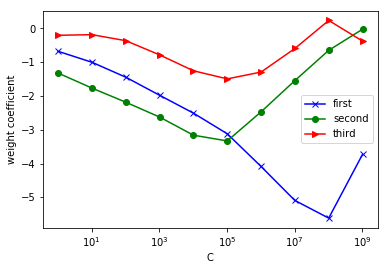

In [202]:
weights, params = [], []
for c in np.arange(0.01, 10): 
    lr = LogisticRegression(C=2**c, random_state=0, solver='lbfgs')
    lr.fit(X_train_std, y_train)
    weights.append(lr.coef_[0])
    params.append(10**c)

weights = np.array(weights)

# Decision region drawing
import matplotlib.pyplot as plt

plt.plot(params, weights[:, 0], color='blue', marker='x', label='first')
plt.plot(params, weights[:, 1], color='green',  marker='o', label='second')
plt.plot(params, weights[:, 2], color='r',  marker='>', label='third')
plt.ylabel('weight coefficient')
plt.xlabel('C')
plt.legend(loc='right')
plt.xscale('log')
plt.show()

In [224]:
#Same but using Stochastic Gradient Descent (SGD) classifier
from sklearn.linear_model import SGDClassifier
sgd_clf = SGDClassifier(random_state=1)
sgd_clf.fit(X_train_std, y_train)

SGDClassifier(alpha=0.0001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='hinge',
              max_iter=1000, n_iter_no_change=5, n_jobs=None, penalty='l2',
              power_t=0.5, random_state=1, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)

In [225]:
sgd_clf.score(X_train_std, y_train)

0.9962540135569034

In [226]:
sgd_clf.score(X_test_std, y_test)

0.9957203994293866

In [227]:
# Just to double check how crazy these results are, lets use cross validation
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train_std, y_train, cv=3, scoring='accuracy')

array([0.99625468, 0.99625468, 0.99625268])

In [228]:
cross_val_score(log_reg, X_train_std, y_train, cv=3, scoring='accuracy')

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.99625468, 0.99571964, 0.99571734])

In [229]:
# Accuracy score is generally not a good performance measure for classifiers, especially when you are dealing with 
# skewed datasets (when some classes are much more frequent than others) -- check with confusing matrix below:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix
sgd_y_train_pred = cross_val_predict(sgd_clf, X_train_std, y_train, cv=3)
confusion_matrix(y_train, sgd_y_train_pred)

array([[5585,    0],
       [  21,    0]])

In [230]:
# Same terrible results for logit regression:
log_y_train_pred = cross_val_predict(log_reg, X_train_std, y_train, cv=3)
confusion_matrix(y_train, log_y_train_pred)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([[5582,    3],
       [  20,    1]])

In [235]:
from sklearn.metrics import precision_score, recall_score, f1_score
precision_score(y_train, sgd_y_train_pred) #SGD precision

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [236]:
precision_score(y_train, log_y_train_pred) #Logit precision

0.25

In [237]:
recall_score(y_train, sgd_y_train_pred) #SGD precision

0.0

In [238]:
recall_score(y_train, log_y_train_pred) #Logit recall

0.047619047619047616

In [239]:
f1_score(y_train, sgd_y_train_pred)

/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


0.0

In [240]:
f1_score(y_train, log_y_train_pred)

0.08

In [252]:
# Precision/Recall tradeoff 
from sklearn.metrics import precision_recall_curve

sgd_y_scores = cross_val_predict(sgd_clf, X_train_std, y_train, cv=3, method='decision_function')
sgd_precisions, sgd_recalls, sgd_thresholds = precision_recall_curve(y_train, sgd_y_scores)

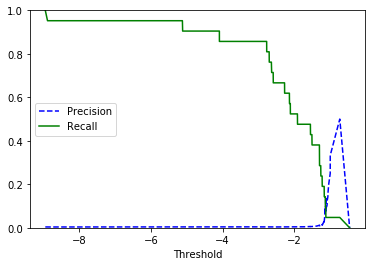

In [253]:
#Represent Precision and Recall graphically
def plot_precision_recall(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[: -1], 'b--', label='Precision')
    plt.plot(thresholds, recalls[: -1], 'g-', label='Recall')
    plt.xlabel('Threshold')
    plt.legend(loc='center left')
    plt.ylim([0,1])

plot_precision_recall(sgd_precisions, sgd_recalls, sgd_thresholds)
plt.show()

In [262]:
# Logit needs predict_proba output fist

# log_y_scores = cross_val_predict(log_reg, X_train_std, y_train, cv=3, method='decison_function')
# log_precisions, log_recalls, log_thresholds = precision_recall_curve(y_train, log_y_scores)
# plot_precision_recall(log_precisions, log_recalls, log_thresholds)
# plt.show()

In [266]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(y_train, sgd_y_scores)

In [273]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([0,1,0,1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Negatove Rate')

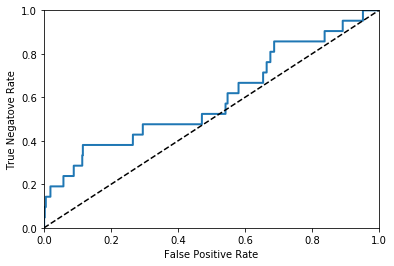

In [274]:
plot_roc_curve(fpr, tpr)
plt.show()

In [336]:
# Checking compositional of the data set by asset size (RCON2170)
all_banks_2010Q4_df= pd.read_csv('data/all_banks_2010Q4.csv', index_col=0)
all_banks_2010Q4_df.head()

,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,Target,AsOfDate
0,21653,4651,14104,186.0,12287,0,0,0.0,2405.0,423.0,177.0,0,9/30/2010
1,54633,14683,32036,20.0,21577,0,0,0.0,7822.0,635.0,1134.0,0,9/30/2010
2,17735,5350,9925,171.0,11137,0,0,0.0,2419.0,404.0,210.0,0,9/30/2010
3,34053,13633,17102,273.0,14809,0,0,0.0,3198.0,655.0,296.0,0,9/30/2010
4,92889,16135,61795,1195.0,63063,0,19,0.0,10273.0,1449.0,1287.0,0,9/30/2010


In [337]:
all_banks_2010Q4_df.drop(['AsOfDate'], axis=1, inplace=True)
all_banks_2010Q4_df.head()

,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,Target
0,21653,4651,14104,186.0,12287,0,0,0.0,2405.0,423.0,177.0,0
1,54633,14683,32036,20.0,21577,0,0,0.0,7822.0,635.0,1134.0,0
2,17735,5350,9925,171.0,11137,0,0,0.0,2419.0,404.0,210.0,0
3,34053,13633,17102,273.0,14809,0,0,0.0,3198.0,655.0,296.0,0
4,92889,16135,61795,1195.0,63063,0,19,0.0,10273.0,1449.0,1287.0,0


In [341]:
#all_banks_2010Q4_df.columns = list(financial_metrics_dict.values())
all_banks_2010Q4_df.head()

,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,Target
0,21653,4651,14104,186.0,12287,0,0,0.0,2405.0,423.0,177.0,0
1,54633,14683,32036,20.0,21577,0,0,0.0,7822.0,635.0,1134.0,0
2,17735,5350,9925,171.0,11137,0,0,0.0,2419.0,404.0,210.0,0
3,34053,13633,17102,273.0,14809,0,0,0.0,3198.0,655.0,296.0,0
4,92889,16135,61795,1195.0,63063,0,19,0.0,10273.0,1449.0,1287.0,0


In [343]:
len(all_banks_2010Q4_df.loc[all_banks_2010Q4_df['RCON2170']==0])
all_banks_2010Q4_df = all_banks_2010Q4_df.loc[all_banks_2010Q4_df['RCON2170'] > 0] # drop zero Total assets
all_banks_2010Q4_df = all_banks_2010Q4_df.loc[all_banks_2010Q4_df['RIAD4340'] > 0] # drop zero Net Income

In [370]:
data = all_banks_2010Q4_df
data.dropna()

,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,Target
5,99624,32923,55534,671.0,68477,0,435,314.0,10493.0,3062.0,201.0,0
9,118418,32879,71634,984.0,65337,0,1703,141.0,10942.0,2806.0,591.0,0
41,198933,35662,139529,954.0,142464,0,248,52.0,17426.0,5066.0,2369.0,0
43,23915,5760,15240,160.0,10375,0,0,4.0,2780.0,640.0,66.0,0
47,30344,7054,20043,182.0,19142,0,56,65.0,3152.0,761.0,267.0,0
56,186656,40247,119628,2216.0,103489,0,151,82.0,24892.0,3352.0,1264.0,0
58,50519,11976,26706,568.0,19096,0,1,7.0,11593.0,983.0,256.0,0
71,353302,71173,214245,1610.0,196787,0,1278,80.0,38514.0,6827.0,2388.0,0
73,60502,13831,37288,478.0,43896,0,0,20.0,5544.0,1634.0,419.0,0
74,248986,77876,124895,2054.0,84133,0,192,6.0,45351.0,3699.0,2686.0,0


In [371]:
data.head()
len(data)

662

In [377]:
yy = data['Target']
XX = data.drop(['Target'], axis=1)

XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2, random_state=1, stratify=y)
scaler = StandardScaler()
scaler.fit(XX_train)
XX_train_std = scaler.transform(XX_train)
XX_test_std = scaler.transform(XX_test)

In [378]:
sgd_clf.score(XX_test_std, yy_test)

0.9924812030075187

In [380]:
sgd_yy_train_pred = cross_val_predict(sgd_clf, XX_train_std, yy_train, cv=3)
confusion_matrix(yy_train, sgd_yy_train_pred)

/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 2 members, which is too few. The minimum number of members in any class cannot be less than n_splits=3.
  % (min_groups, self.n_splits)), Warning)


array([[527,   0],
       [  2,   0]])

In [381]:
len(data)

662

In [376]:
len(X_train_std)

529

In [382]:
log_reg.fit(XX_train_std, yy_train)

/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1000.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=1, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [384]:
log_reg.score(XX_test_std, yy_test)

0.9924812030075187

In [255]:
softmax_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', C=10)
softmax_reg.fit(X_train_std, y_train)

LogisticRegression(C=10, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [256]:
softmax_reg.score(X_test_std, y_test)

0.9957203994293866

In [257]:
softmax_reg.coef_

array([[-1.32916632, -1.67116816, -0.68557074, -0.25403833, -0.19955891,
        -0.14567773,  0.26596365, -0.12875243, -5.17203616, -0.16548136,
        -1.32227245]])

In [258]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC

In [259]:
svm_clf = LinearSVC(C=1, loss='hinge')
svm_clf.fit(X_train_std, y_train)
svm_clf.score(X_test_std, y_test)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


0.9964336661911555

In [260]:
svm_clf = Pipeline([
    ('scaler', StandardScaler()),
    ('linear_svc', LinearSVC(C=1, loss='hinge')),
])

svm_clf.fit(X_train, y_train)

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('linear_svc',
                 LinearSVC(C=1, class_weight=None, dual=True,
                           fit_intercept=True, intercept_scaling=1,
                           loss='hinge', max_iter=1000, multi_class='ovr',
                           penalty='l2', random_state=None, tol=0.0001,
                           verbose=0))],
         verbose=False)

In [261]:
svm_clf.score(X_test, y_test)

0.9964336661911555

In [137]:
all_banks_2010Q4_df = pd.read_csv('data/all_banks_2010Q4.csv', index_col=0)

In [138]:
len(all_banks_2010Q4_df.loc[all_banks_2010Q4_df.Target==1])

27

In [155]:
# Add CAMELS columns to all_banks_2010Q4
all_banks_2010Q4_df= pd.read_csv('data/all_banks_2010Q4.csv', index_col=0)
len(all_banks_2010Q4_df)

7121

In [156]:
all_banks_2010Q4_df.drop(['AsOfDate'], axis=1, inplace=True)
len(all_banks_2010Q4_df)

7121

In [157]:
all_banks_2010Q4_df.dropna(inplace=True)
len(all_banks_2010Q4_df)

7008

In [158]:
#data = all_banks_2010Q4_df[all_banks_2010Q4_df['RCON2170']>0] # drop zero Total assets
#len(data)
#df3 = result[result['Value'] > 10]  

In [159]:
#data = all_banks_2010Q4_df[all_banks_2010Q4_df['RIAD4340']>0] # drop zero Net Income
#len(data)

In [160]:
#data = all_banks_2010Q4_df[all_banks_2010Q4_df['RCON3123']>0]# drop zero Allowance for loan and lease losses
#len(data)

In [161]:
data = all_banks_2010Q4_df
len(data.loc[data.Target==1])

26

In [162]:
len(data.loc[data.RCON3123 == 0]) #<-- abks with 0 Allowance for loan and lease losses

6880

In [163]:
XXX = data
XXX.head(2)

,RIAD3210,RCON2170,RCON3360,RCONC410,RCONC411,RCON3123,RIAD4093,RIAD4340,RCON2215,RCON2385,RCON3545,Target
0,21653,4651,14104,186.0,12287,0,0,0.0,2405.0,423.0,177.0,0
1,54633,14683,32036,20.0,21577,0,0,0.0,7822.0,635.0,1134.0,0


In [164]:
# 1) Total Equity / Total Assets (EQTA)
XXX['EQTA'] = XXX['RIAD3210']/XXX['RCON2170'] # <-- Total assest is a problem
# 2) Total Equity / Total Loans (EQTL)
XXX['EQTL'] = XXX['RIAD3210']/XXX['RCON3360'] 
# 3) NPLTA = Non Performing Loans / Total Assets
XXX['NPLTA']= (XXX['RCONC410'] + XXX['RCONC411']) / XXX['RCON2170'] 
#RCONC410  #Additions to nonaccrual assets during the previous six months
#RCONC411 # Nonaccrual assets sold during the previous six months


# 4) LLRTA = Loan Loss Reserves / Total Assest
XXX['LLRTA'] = XXX['RCON3123'] / XXX['RCON2170']
#RCON3123     # Allowance for loan and lease losses

# 5) #LLRGL = Loan Loss Reserves / Gross Loans (LLRGL)
XXX['LLRGL'] = XXX['RCON3123'] / XXX['RCON3360']

# 6) Operating Expenses / Assets (OEXTA)
XXX['OEXTA'] = XXX['RIAD4093'] / XXX['RCON2170']


# 7) Net Income / Total Assest (ROA)
# RIAD4340    # Net Income (Net income (loss) attributable to bank (item 12 minus item 13).)
XXX['ROA'] = XXX['RIAD4340'] / XXX['RCON2170']

# 8) Net Income / Total Equity (ROE)
XXX['ROE'] = XXX['RIAD4340'] / XXX['RIAD3210']

# 9) Total Loans / Total Customer Deposits (TLTD)
XXX['TLTD'] = XXX['RCON3360'] / (XXX['RCON2215']+XXX['RCON2385'])
#  RCON2215  # Total transaction accounts deposits 
#  RCON2385  # Total non-transaction accounts 
#
#
# 10) Total Customer Deposits / Total Assest (TDTA)
XXX['TDTA'] = (XXX['RCON2215'] + XXX['RCON2385'])/ XXX['RCON2170']
#
# 11) (S)ensitivity to market risk (TATA) = Trading Assets /Total assest
XXX['TATA'] = XXX['RCON3545'] / XXX['RCON2170']
#  RCON3545 # Trading Assets /Total assets

XXX.columns
X_CAMELS = XXX.drop(columns = ['RIAD3210', 'RCON2170', 'RCON3360', 'RCONC410', 'RCONC411', 'RCON3123',
       'RIAD4093', 'RIAD4340', 'RCON2215', 'RCON2385', 'RCON3545'], axis=1)

In [165]:
X_CAMELS.head(2)

,Target,EQTA,EQTL,NPLTA,LLRTA,LLRGL,OEXTA,ROA,ROE,TLTD,TDTA,TATA
0,0,4.655558,1.535238,2.681789,0.0,0.0,0.0,0.0,0.0,4.987270,0.608041,0.038056
1,0,3.720834,1.705363,1.470885,0.0,0.0,0.0,0.0,0.0,3.788105,0.575972,0.077232


In [166]:
X_CAMELS.replace([np.inf, -np.inf], np.nan)
#df.replace([np.inf, -np.inf], np.nan)
X_CAMELS.dropna
len(X_CAMELS)

7008

In [167]:
X_CAMELS.tail(10)

,Target,EQTA,EQTL,NPLTA,LLRTA,LLRGL,OEXTA,ROA,ROE,TLTD,TDTA,TATA
7111,1,32.853637,1.099285,21.952097,0.0,0.0,1.486349,0.000000,0.000000,40.572945,0.736608,-1.437306
7112,1,4.331773,1.401450,3.478349,0.0,0.0,0.028204,0.000000,0.000000,11.508770,0.268571,-0.058522
7113,1,6.825984,1.213668,5.398544,0.0,0.0,0.835526,0.000000,0.000000,17.120118,0.328518,-0.382480
7114,1,1.921900,2.513012,1.028245,0.0,0.0,0.000000,0.000000,0.000000,8.275053,0.092420,-0.108907
7115,1,16.984238,1.166650,15.485223,0.0,0.0,0.241268,0.000000,0.000000,21.679915,0.671503,-0.550958
7116,1,8.595581,1.162332,6.765814,0.0,0.0,0.229767,0.000000,0.000000,43.679945,0.169302,-0.713721
7117,1,16.724116,1.221146,12.942798,0.0,0.0,0.865278,0.000000,0.000000,23.753496,0.576565,-0.566000
7118,1,12.949108,1.385623,10.245169,0.0,0.0,0.163003,0.000000,0.000000,19.934550,0.468801,-0.510252
7119,1,4.657617,1.315488,3.717778,0.0,0.0,0.000000,0.000000,0.000000,13.751167,0.257476,-0.205681
7120,1,18.906830,1.162593,14.915997,0.0,0.0,0.508203,0.016923,0.000895,12.817896,1.268744,-0.754901


In [170]:
yyy = X_CAMELS['Target']
XXX = X_CAMELS.drop(['Target'], axis=1)
XXX.head(20)

,EQTA,EQTL,NPLTA,LLRTA,LLRGL,OEXTA,ROA,ROE,TLTD,TDTA,TATA
0,4.655558,1.535238,2.681789,0.0,0.0,0.000000,0.000000,0.000000,4.987270,0.608041,0.038056
1,3.720834,1.705363,1.470885,0.0,0.0,0.000000,0.000000,0.000000,3.788105,0.575972,0.077232
2,3.314953,1.786902,2.113645,0.0,0.0,0.000000,0.000000,0.000000,3.515763,0.527664,0.039252
3,2.497836,1.991171,1.106286,0.0,0.0,0.000000,0.000000,0.000000,4.438619,0.282623,0.021712
4,5.756988,1.503180,3.982522,0.0,0.0,0.001178,0.000000,0.000000,5.271711,0.726495,0.079764
5,3.025970,1.793928,2.100295,0.0,0.0,0.013213,0.009537,0.003152,4.096938,0.411718,0.006105
6,2.392901,2.471104,1.685998,0.0,0.0,0.000000,0.000000,0.000000,2.127751,0.455106,0.018001
7,2.508977,2.390926,0.440205,0.0,0.0,0.000000,0.000000,0.000000,2.225774,0.471465,0.010099
8,4.841438,1.560249,4.237995,0.0,0.0,0.000000,0.000000,0.000000,3.477996,0.892178,0.019934
9,3.601630,1.653098,2.017123,0.0,0.0,0.051796,0.004288,0.001191,5.210503,0.418139,0.017975


In [171]:
XXX_train, XXX_test, yyy_train, yyy_test = train_test_split(XXX, yyy, test_size=0.2, stratify=yyy)
#XX_train, XX_test, yy_train, yy_test = train_test_split(XX, yy, test_size=0.2, random_state=1, stratify=y)
scaler = StandardScaler()
scaler.fit(XXX_train)
XXX_train_std = scaler.transform(XXX_train)
XXX_test_std = scaler.transform(XXX_test)

/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


ValueError: Input contains infinity or a value too large for dtype('float64').

In [11]:
#EQTA = RIAD3210 / RCON2170 # 1) Total Equity / Total Assets (EQTA) = 0.08 for ID=367851

#RCON3360 = report_df.loc[report_df.ValueID == 'RCON3360'] #Total loans of 16517  for ID=367851
#EQTL = RCONG105 / RCON3360 # Total Equity / Total Loans (EQTL)

#NPLTA = Non Performing Loans / Total Assets (NPLTA)
#RCONC410  #Additions to nonaccrual assets during the previous six months
#RCONC411 # Nonaccrual assets sold during the previous six months

#LLRTA = Loan Loss Reserves / Total Assest
# RCON3123     # Allowance for loan and lease losses

#LLRGL = Loan Loss Reserves / Gross Loans (LLRGL)


# (M)anagement quality
#       7) Operating Expenses / Assets (OEXTA)
# RIAD4093 # Total noninterest expense (sum of items 7.a through 7.d).




#       - Operating Costs / Net Operating Income (OCNOI)
#
#
# (E)arnings ability
#       8) Net Income / Total Assest (ROA)
# RIAD4340    # Net Income (Net income (loss) attributable to bank (item 12 minus item 13).)
#       9) Net Income / Total Equity (ROE)
# 
#
#
#(L)iquidity, i.e. ability to fulfill its short-term liability
#       10) Total Loans / Total Customer Deposits (TLTD)
#  RCON2215  # Total transaction accounts deposits 
#  RCON2385  # Total non-transaction accounts 
#
#
#       11) Total Customer Deposits / Total Assest (TDTA)
#
#
#
# (S)ensitivity to market risk 
#  RCON3545 # Trading Assets /Total assest
#
#
#  Schedule RC-B: Securities 
#  RCON1754 # (Column A) Held-to-maturity Amortized Cost
#  RCON1771 # (Column B) Held-to-maturity Fair Value
#  RCON1772 # (Column C) Available-for-sale Amortized Cost
#  RCON1773 # (Column D) Available-for-sale Fair Value
